In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
data = pd.read_csv("/content/drive/My Drive/NLP/rs_telco.csv")
data.head(5)

,id,title,link,published,text,service_provider,col
0,0,NaN,https://www.reviewsrilanka.com/lankabell-revie...,"January 18, 2021 at 9:56 am",20MBps Speed Location Kadawatha5 Star Customer...,lankabell-review,neutral
1,1,NaN,https://www.reviewsrilanka.com/lankabell-revie...,"January 10, 2021 at 10:52 pm",Lankabell is good enough with download speed a...,lankabell-review,neutral
2,2,4G thiyenne samahara than walata witharai,https://www.reviewsrilanka.com/lankabell-revie...,"September 12, 2020 at 7:51 am",wattala area eke 4G naha. eka eka than walata ...,lankabell-review,neutral
3,3,UNLIMITED PACKAGE,https://www.reviewsrilanka.com/dialog-axiata-r...,"December 28, 2021 at 2:40 pm",BROADBAND UNLIMITED PACKAGE නම් පට්ට හොදේ(RS.2...,dialog-axiata-review,neutral
4,4,NaN,https://www.reviewsrilanka.com/dialog-axiata-r...,"December 20, 2021 at 5:41 pm",very low speed.worst isp in sri lanka,dialog-axiata-review,negative


In [5]:
del data['title']
del data['id']
del data['link']
data.head()

,published,text,service_provider,col
0,"January 18, 2021 at 9:56 am",20MBps Speed Location Kadawatha5 Star Customer...,lankabell-review,neutral
1,"January 10, 2021 at 10:52 pm",Lankabell is good enough with download speed a...,lankabell-review,neutral
2,"September 12, 2020 at 7:51 am",wattala area eke 4G naha. eka eka than walata ...,lankabell-review,neutral
3,"December 28, 2021 at 2:40 pm",BROADBAND UNLIMITED PACKAGE නම් පට්ට හොදේ(RS.2...,dialog-axiata-review,neutral
4,"December 20, 2021 at 5:41 pm",very low speed.worst isp in sri lanka,dialog-axiata-review,negative


In [6]:
data= data[data.text.map(lambda x: x.isascii())]
data.head(20)

,published,text,service_provider,col
0,"January 18, 2021 at 9:56 am",20MBps Speed Location Kadawatha5 Star Customer...,lankabell-review,neutral
1,"January 10, 2021 at 10:52 pm",Lankabell is good enough with download speed a...,lankabell-review,neutral
2,"September 12, 2020 at 7:51 am",wattala area eke 4G naha. eka eka than walata ...,lankabell-review,neutral
4,"December 20, 2021 at 5:41 pm",very low speed.worst isp in sri lanka,dialog-axiata-review,negative
5,"December 13, 2021 at 9:29 am",Signal na poddak vath. Melo rahak na.,dialog-axiata-review,neutral
6,"December 12, 2021 at 10:31 pm",not bad for broadband,dialog-axiata-review,neutral
7,"December 12, 2021 at 9:32 pm",anagathaya adai,dialog-axiata-review,neutral
8,"December 12, 2021 at 8:48 am","best mobile,fixed network.",dialog-axiata-review,neutral
9,"December 4, 2021 at 8:09 pm",Bloody worst service ever,dialog-axiata-review,negative
10,"November 15, 2021 at 12:07 am",worst connection in sri lanka,dialog-axiata-review,negative


Text(0.5, 1.0, 'Dataset labels distribuition')

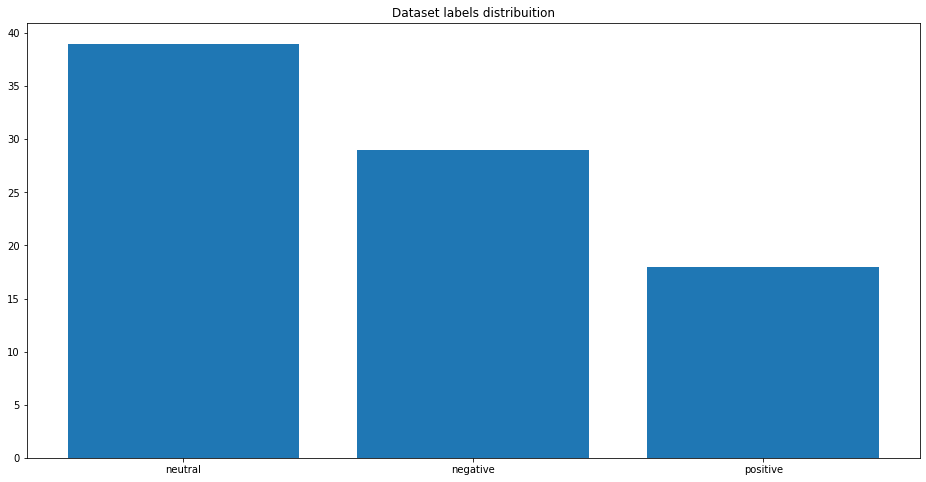

In [7]:
target_cnt = Counter(data.col)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [8]:
# DATASET
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [9]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
data.text = data.text.apply(lambda x: preprocess(x))
data.head(10)

,published,text,service_provider,col
0,"January 18, 2021 at 9:56 am",20mbps speed location kadawatha5 star customer...,lankabell-review,neutral
1,"January 10, 2021 at 10:52 pm",lankabell good enough download speed around 3m...,lankabell-review,neutral
2,"September 12, 2020 at 7:51 am",wattala area eke 4g naha eka eka walata withar...,lankabell-review,neutral
4,"December 20, 2021 at 5:41 pm",low speed worst isp sri lanka,dialog-axiata-review,negative
5,"December 13, 2021 at 9:29 am",signal na poddak vath melo rahak na,dialog-axiata-review,neutral
6,"December 12, 2021 at 10:31 pm",bad broadband,dialog-axiata-review,neutral
7,"December 12, 2021 at 9:32 pm",anagathaya adai,dialog-axiata-review,neutral
8,"December 12, 2021 at 8:48 am",best mobile fixed network,dialog-axiata-review,neutral
9,"December 4, 2021 at 8:09 pm",bloody worst service ever,dialog-axiata-review,negative
10,"November 15, 2021 at 12:07 am",worst connection sri lanka,dialog-axiata-review,negative


In [12]:
df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 68
TEST size: 18


In [13]:
documents = [_text.split() for _text in df_train.text]

In [14]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [15]:
w2v_model.build_vocab(documents)

2022-01-16 03:53:08,463 : INFO : collecting all words and their counts
2022-01-16 03:53:08,465 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-16 03:53:08,468 : INFO : collected 369 word types from a corpus of 706 raw words and 68 sentences
2022-01-16 03:53:08,473 : INFO : Loading a fresh vocabulary
2022-01-16 03:53:08,475 : INFO : effective_min_count=10 retains 9 unique words (2% of original 369, drops 360)
2022-01-16 03:53:08,476 : INFO : effective_min_count=10 leaves 141 word corpus (19% of original 706, drops 565)
2022-01-16 03:53:08,478 : INFO : deleting the raw counts dictionary of 369 items
2022-01-16 03:53:08,480 : INFO : sample=0.001 downsamples 9 most-common words
2022-01-16 03:53:08,481 : INFO : downsampling leaves estimated 14 word corpus (10.3% of prior 141)
2022-01-16 03:53:08,482 : INFO : estimated required memory for 9 words and 300 dimensions: 26100 bytes
2022-01-16 03:53:08,484 : INFO : resetting layer weights


In [16]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 9


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-01-16 03:53:13,094 : INFO : training model with 8 workers on 9 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-01-16 03:53:13,106 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-01-16 03:53:13,108 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-01-16 03:53:13,110 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-01-16 03:53:13,111 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-01-16 03:53:13,112 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-01-16 03:53:13,114 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-01-16 03:53:13,115 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-01-16 03:53:13,117 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-01-16 03:53:13,118 : INFO : EPOCH - 1 : training on 706 raw words (12 effective words) took 0.0s, 786 effective words/s
2

CPU times: user 665 ms, sys: 82.5 ms, total: 747 ms
Wall time: 900 ms


(478, 22592)

In [18]:
w2v_model.most_similar("bad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2022-01-16 03:53:16,439 : INFO : precomputing L2-norms of word weight vectors


[('internet', 0.04554971307516098),
 ('service', -0.014326096512377262),
 ('customer', -0.03910325840115547),
 ('good', -0.04070918262004852),
 ('coverage', -0.057112254202365875),
 ('speed', -0.06025635823607445),
 ('4g', -0.06761521100997925),
 ('connection', -0.06854835152626038)]

In [19]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 370
CPU times: user 1.88 ms, sys: 1 ms, total: 2.88 ms
Wall time: 2.79 ms


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 2.62 ms, sys: 955 µs, total: 3.57 ms
Wall time: 4.35 ms


In [21]:
labels = df_train.col.unique().tolist()
labels

['neutral', 'positive', 'negative']

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.col.tolist())

y_train = encoder.transform(df_train.col.tolist())
y_test = encoder.transform(df_test.col.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (68, 1)
y_test (18, 1)


In [23]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(370, 300)


In [24]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          111000    
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 271,501
Trainable params: 160,501
Non-trainable params: 111,000
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [27]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [28]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.3443WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:47,816 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 5s 5s/step - loss: 0.6931 - accuracy: 0.3443 - val_loss: 0.6962 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 2/8
1/1 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.4262WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:49,149 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 1s 1s/step - loss: 0.6867 - accuracy: 0.4262 - val_loss: 0.7000 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 3/8
1/1 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.4262WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:50,517 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 1s 1s/step - loss: 0.6791 - accuracy: 0.4262 - val_loss: 0.7048 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 4/8
1/1 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.4262WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:51,854 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 1s 1s/step - loss: 0.6695 - accuracy: 0.4262 - val_loss: 0.7111 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 5/8
1/1 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.4262WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:53,221 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 1s 1s/step - loss: 0.6578 - accuracy: 0.4262 - val_loss: 0.7198 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 6/8
1/1 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.4262WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:54,566 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 1s 1s/step - loss: 0.6416 - accuracy: 0.4262 - val_loss: 0.7328 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 7/8
1/1 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.4262WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:55,877 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 1s 1s/step - loss: 0.6201 - accuracy: 0.4262 - val_loss: 0.7345 - val_accuracy: 0.2857 - lr: 1.0000e-04
Epoch 8/8
1/1 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.4262WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 03:53:57,205 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1/1 [==============================] - 1s 1s/step - loss: 0.6174 - accuracy: 0.4262 - val_loss: 0.7363 - val_accuracy: 0.2857 - lr: 1.0000e-04
CPU times: user 22.2 s, sys: 2.06 s, total: 24.3 s
Wall time: 23.7 s


In [29]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 107ms/step - loss: 0.6366 - accuracy: 0.6111

ACCURACY: 0.6111111044883728
LOSS: 0.6366446018218994
CPU times: user 224 ms, sys: 3.72 ms, total: 227 ms
Wall time: 149 ms


In [30]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [31]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [32]:
predict("I hate the connection")

{'elapsed_time': 0.3865623474121094,
 'label': 'NEUTRAL',
 'score': 0.545252799987793}

In [33]:
y_pred_1d = []
y_test_1d = list(df_test.col)
scores = model.predict(x_test, verbose=1, batch_size=80)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 0s 352ms/step


In [34]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


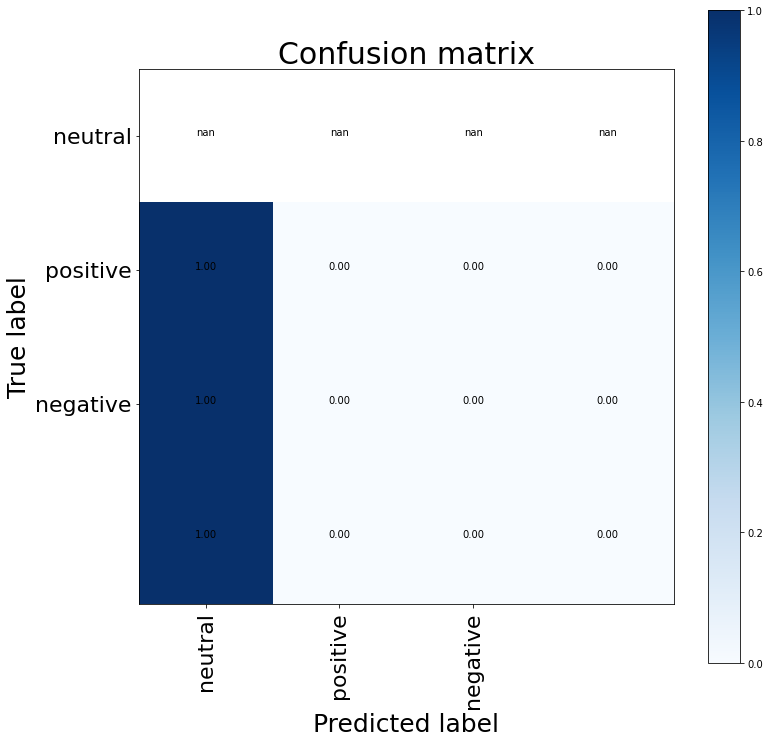

In [35]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.col.unique(), title="Confusion matrix")
plt.show()